### Define topology

In [318]:
import numpy as np
import matplotlib.pyplot as plt
import random

from codes.utils import printoptions
from codes.graph_utils import Graph, spectral_gap


class TunableChain(Graph):

    def __init__(self, a, b, mixing, delta_max, p):
        self.a = a
        self.b = b
        self.delta_max = delta_max
        self.p = p

        if delta_max > 1-a-b:
            raise NotImplementedError
        
        metropolis = np.zeros((6, 6))
        metropolis[2:, 2:] = mixing
        metropolis[0, 0] = 1 - delta_max
        metropolis[0, 3] = delta_max
        metropolis[3, 0] = delta_max
        metropolis[3, 3] -= delta_max

        metropolis[1, 1] = 1 - delta_max
        metropolis[1, 4] = delta_max
        metropolis[4, 1] = delta_max
        metropolis[4, 4] -= delta_max

        self.metropolis_weight = metropolis

    
    def get_neighbors_index(self, node, include_self):
        if node == 0:
            return [0, 3] if include_self else [3]
        
        if node == 1:
            return [1, 4] if include_self else [4]
        
        if node == 2:
            return [2, 3] if include_self else [3] 
        
        if node == 3:
            return [0, 2, 3, 4] if include_self else [0, 2, 4]

        if node == 4:
            return [1, 3, 4, 5] if include_self else [1, 3, 5]
        
        if node == 5:
            return [4, 5] if include_self else [4]
        
        raise NotImplementedError

    def get_neighbors_weight(self, node, include_self): #wij given i, wij = wji
        indices = self.get_neighbors_index(node, include_self)
        weights = [self.metropolis_weight[node][j] for j in indices]
        return weights
    
    def get_good_neighbors_index(self, node, include_self):
        indices = self.get_neighbors_index(node, include_self)
        return [i for i in indices if i not in [0, 1]]

    def delta_i(self, good_node):
        return self.metropolis_weight[good_node, 0] + self.metropolis_weight[good_node, 1]


class DataManager(object):
    
    def __init__(self, data, graph, attacker):
        assert len(data) == 4

        self.good_data = data
        self.graph = graph
        self.attacker = attacker
        attacker.configure(self, graph)
    
    def getDataOn(self, node): #theta ji given i
        data = [self.attacker(0), self.attacker(1)] + self.good_data
        indices = self.graph.get_neighbors_index(node, include_self=True)
        return [data[i][node] for i in indices]

    def setGoodData(self, data):
        self.good_data = data

    def getGoodData(self, good_node):
        return self.good_data[good_node - 2]
    
    def getState(self): # array of theta i
        data = [self.attacker(0), self.attacker(1)] + self.good_data
        data = [data[i][i] for i in range(len(data))]
        return data
    
    def getGoodState(self): # array of theta i
        data = self.good_data
        data = [data[i][i] for i in range(len(data))]
        return data

class Attack(object):

    def configure(self, data_manager, graph):
        self.data_manager = data_manager
        self.graph = graph

    def __call__(self, byzantine_node):
        pass


class RandomAttack(Attack):
    def __init__(self, a, b, n):
        self.a = a
        self.b = b
        self.n = n
        
    def __call__(self, byzantine_node): #theta ij 
        if byzantine_node == 0 or byzantine_node == 1:
            return [float(random.randint(self.a, self.b)) for i in range(self.n)]

class ConstValueAttack(Attack):
    def __init__(self, v0, v1, n):
        self.v0 = [v0 for i in range(n)]
        self.v1 = [v1 for i in range(n)]
        self.n = n

    def __call__(self, byzantine_node):
        if byzantine_node == 0:
            return self.v0
        if byzantine_node == 1:
            return self.v1
        raise NotImplementedError
        
class RandomConsistentAttack(Attack):
    def __init__(self, a, b, n):
        self.a = a
        self.b = b
        self.n = n
        
    def __call__(self, byzantine_node): 
        if byzantine_node == 0 or byzantine_node == 1:
            rand = float(random.randint(self.a, self.b))
            return [rand for i in range(self.n)]
        
class InconsistentAttack(Attack):
    def __init__(self, a, b, n):        
        self.v0 = [float(random.randint(a, b)) for i in range(n)]
        self.v1 = [float(random.randint(a, b)) for i in range(n)]
        
    def __call__(self, byzantine_node): 
        if byzantine_node == 0:
            return self.v0
        if byzantine_node == 1:
            return self.v1
        raise NotImplementedError

class DissensusAttack(Attack):

    def __init__(self, eps, n):
        self.eps = eps
        self.n = n

    def __call__(self, byzantine_node):
        data = self.data_manager.good_data        
        m = self.graph.metropolis_weight[4 if byzantine_node else 3]
        if byzantine_node == 0:
            v = m[2] * (data[0][0] - data[1][0]) + m[4] * (data[2][0] - data[1][0])
            v /= m[0]
            return [data[1][0] - self.eps * v for i in range(self.n)]

        if byzantine_node == 1:
            v = m[3] * (data[1][1] - data[2][1]) + m[5] * (data[3][1] - data[2][1])
            v /= m[1]
            return [data[2][1] - self.eps * v for i in range(self.n)]

        raise NotImplementedError
        
class SandTrapAttack(Attack):

    def __init__(self, weight_v, weight_r, n):
        self.weight_v = weight_v
        self.weight_r = weight_r
        self.n = n

    def __call__(self, byzantine_node):
        victim = 3
        
        data = self.data_manager.good_data 
        # - neighbors*weight_contrib - itself*weight_contrib
        m3 = self.graph.metropolis_weight[3]
        v = -data[3-2][3]*m3[3] - data[2-2][3]*m3[2] - data[4-2][3]*m3[4]

        m4 = self.graph.metropolis_weight[4]
        # +neighbors*weight_contrib + itself*weight_contrib
        w = data[3-2][3]*m4[3] + data[2-2][3]*m4[2] + data[4-2][3]*m4[4]
            
        if byzantine_node == 0:
            v /= m3[0]
            theta3 = v
            
            w /= m4[0] 
            theta4 = w
            return [0, 0, 0, theta3, theta4, 0]

        if byzantine_node == 1:
            v /= m3[1]
            theta3 = v 
            
            w /= m4[1]
            theta4 = w
            return [0, 0, 0, theta3, theta4, 0]
        
        raise NotImplementedError
        
class EchoAttack(Attack):

    def __init__(self, s, c, n):
        self.s = s
        self.n = n
        self.c = c

    def __call__(self, byzantine_node):
        victim = 3
        
        data = self.data_manager.good_data   
        m3 = self.graph.metropolis_weight[3]
        # send sum (theta3 - neighbor_contrib)*weight contrib to victim
        v = data[3-2][3]*m3[3] + self.c*((data[3-2][3]-data[2-2][3])*m3[2] + (data[3-2][3] - data[4-2][3])*m3[4])
        #v = data[3-2][3]*m[3] + self.c*(-data[2-2][3]*m[2] - data[4-2][3]*m[4])
        
        m4 = self.graph.metropolis_weight[4]
        # send ( sum (neighbor_contrib - theta3)*weight contrib ) to neighbors of 3 (i.e. 4)
        w = -(data[3-2][4]*m4[3] + self.s*((data[3-2][4]-data[5-2][4])*m4[5]))
        
        if byzantine_node == 0:
            v /= m3[0]
            theta3 = v
            
            w /= m4[0] 
            theta4 = w
            return [0, 0, 0, theta3, theta4, 0]

        if byzantine_node == 1:
            v /= m3[1]
            theta3 = v 
        
            w /= m4[1]
            theta4 = w
            return [0, 0, 0, theta3, theta4, 0]

        raise NotImplementedError

In [319]:
class Experiment(object):

    def __init__(self, data_manager, graph, n, b, p, delta_max, T):
        # Number of workers
        self.n = n
        # Number of Byzantine workers
        self.b = b
        self.p = p
        self.delta_max = delta_max
        self.T = T

        self.data_manager = data_manager
        self.graph = graph
        data = self.data_manager.getGoodState()
        self.mu0 = sum(data) / len(data)

        self.consensus_distances = []
        self.errors = []

    def consensus_distance(self):
        data = self.data_manager.getGoodState()
        mu = sum(data) / len(data)
        return sum((i - mu) ** 2 for i in data) / len(data)

    def error(self):
        data = self.data_manager.getGoodState()
        return sum((i - self.mu0) ** 2 for i in data) / len(data)

    def run(self):
        self.consensus_distances.append(self.consensus_distance())
        self.errors.append(self.error())
        for t in range(self.T):
            new_data = []
            for i in range(self.b, self.n):
                # Aggregation on good worker i
                new_data.append(self.agg(i))
            self.data_manager.setGoodData(new_data)
            self.consensus_distances.append(self.consensus_distance())
            self.errors.append(self.error())

    def agg(self, i):
        raise NotImplementedError



# SSClip
def clip(v, tau):
    v_norm = abs(v)
    scale = min(1, tau / v_norm)
    return v * scale

class SSClip(Experiment):

    def agg(self, i):
        data = self.data_manager.getState()
        v = data[i]

        delta_i = self.graph.delta_i(i)
        good_local_indices = self.graph.get_good_neighbors_index(i, include_self=False)

        tau = 0
        for j in good_local_indices:
            w = self.graph.metropolis_weight[i][j]
            d = data[j]
            distance = (d - v) ** 2
            tau += w * distance
        
        if delta_i == 0:
            tau = np.inf
        else:
            tau /= delta_i
            tau = np.sqrt(tau)
        
        #print("tau", tau)

        local_data = self.data_manager.getDataOn(i) #attacker updates here
        weights = self.graph.get_neighbors_weight(i, include_self=True)
        new_data = 0
        a = []
        for index, vv, w in zip(self.graph.get_neighbors_index(i, include_self=True), local_data, weights):
            if vv == v:
                z = v
            else:
                z = v + clip(vv - v, tau)
            new_data += w * z
            a.append(f"Clip node {index} from {vv} to {z}")
        
        return [new_data for i in range(self.n)]



Note that combining median/trimmed mean with mixing matrix is tricky because:

- If we ignore the mixing matrix, then they are robust to the dissensus attack.
- If we consider the mixing matrix, that is, duplicate values according to the mixing weight, then they are no longer cursed by heterogeneity. (This is however not the implementation of Bridge.)

In [325]:
N = 6
b = 2
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

a = 1 / 3
results = []
for attacker, attack_name in [(ConstValueAttack(0, 200, N), "constant"), (DissensusAttack(1, N), "dissensus"), 
                              (RandomAttack(-200,200, N), "random"), (RandomConsistentAttack(-200,200,N), "consistent"), 
                              (InconsistentAttack(-200, 200, N), "inconsistent"),
                              (SandTrapAttack(1, 1, N), "sandtrap"), (EchoAttack(1, 1, N), "echo")]:
    Defense, defense_name = SSClip, "SSClip"
    for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
        for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
            mixing = np.array([
                [1-a, a, 0, 0],
                [a, 1-a-beta, beta, 0],
                [0, beta, 1-a-beta, a],
                [0, 0, a, 1-a]
            ])
            p = spectral_gap(mixing) ** 2
            try:
                graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
                data_manager = DataManager(data0, graph, attacker)
                runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                runner.run()
                results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
            except:
                pass


/var/folders/h4/dsx18qqn0nv5bs61qjpy1c9h0000gp/T/ipykernel_6770/1781648578.py:200: RuntimeWarning: divide by zero encountered in double_scalars
  w /= m4[0]
/var/folders/h4/dsx18qqn0nv5bs61qjpy1c9h0000gp/T/ipykernel_6770/1781648578.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  v /= m3[1]
/var/folders/h4/dsx18qqn0nv5bs61qjpy1c9h0000gp/T/ipykernel_6770/1781648578.py:238: RuntimeWarning: divide by zero encountered in double_scalars
  w /= m4[0]
/var/folders/h4/dsx18qqn0nv5bs61qjpy1c9h0000gp/T/ipykernel_6770/1781648578.py:243: RuntimeWarning: divide by zero encountered in double_scalars
  v /= m3[1]


### Performance of aggregators under constant value attack

Note that this part of result is not included in the paper.

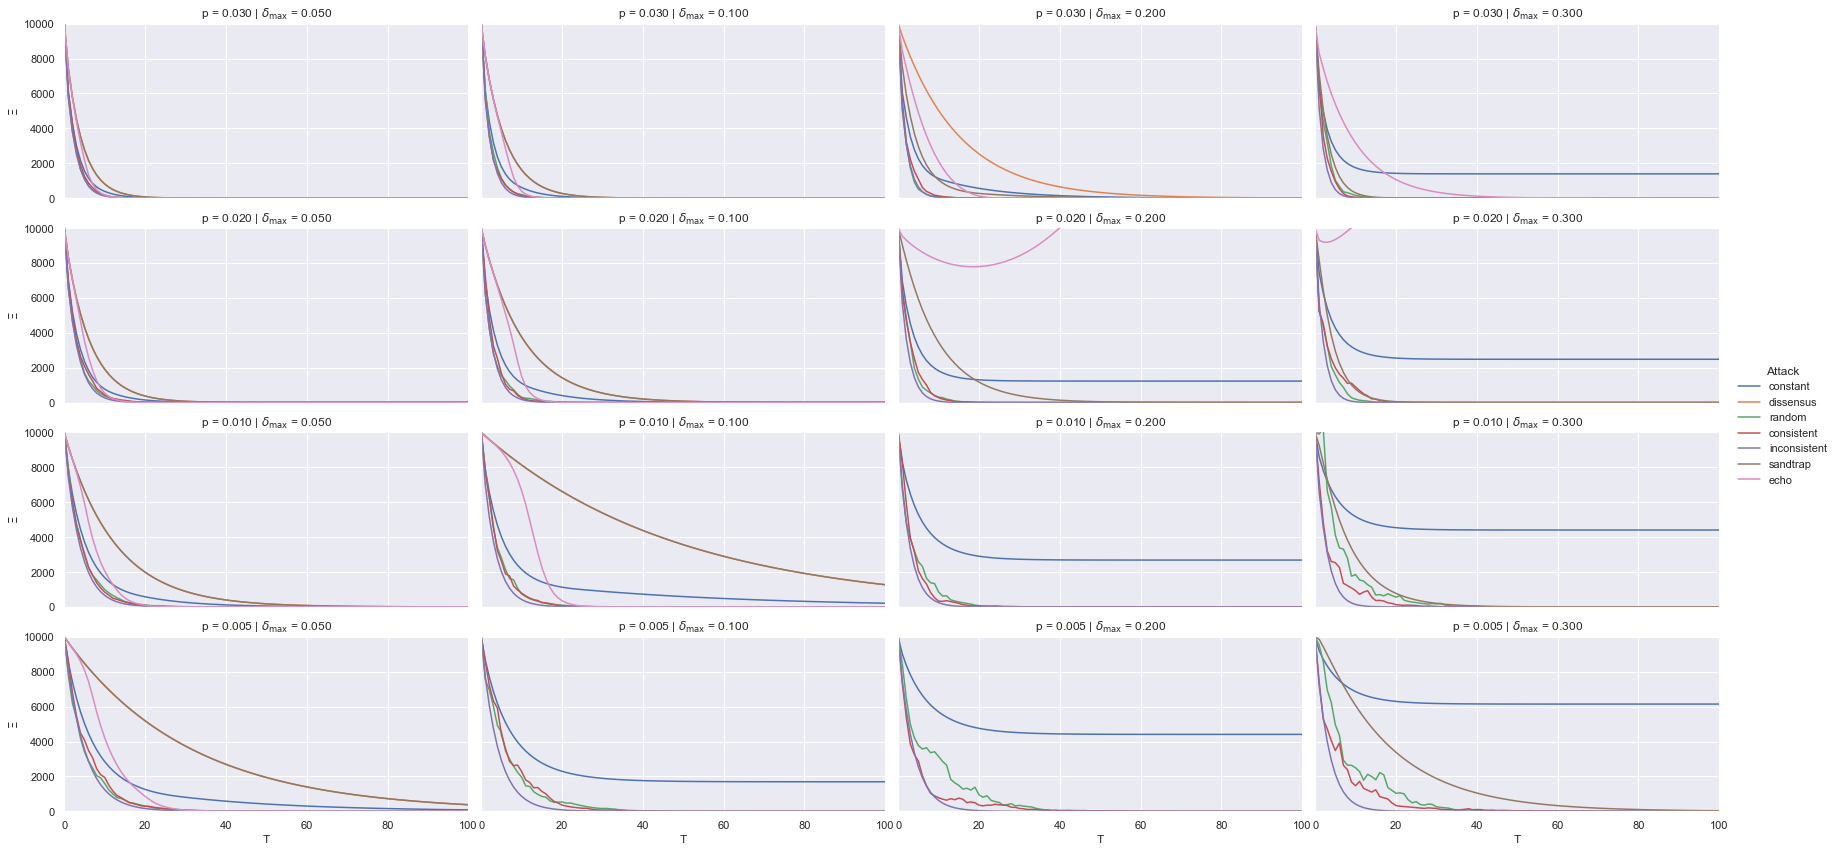

In [326]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Attack": res['attack']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", height=3, aspect=2)

g.set(xlim=(0, 100))
g.set(ylim=(0, 10000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

### Per node consensus

In [314]:
class SSClipBis(SSClip):
    
    def consensus_node(self):
        data = self.data_manager.getGoodState()
        mu = sum(data) / len(data)
        return [sum((i - j) ** 2 for i in data) / len(data) for j in data]

    def run(self):
        self.consensus_distances.append(self.consensus_node())
        self.errors.append(self.error())
        for t in range(self.T):
            new_data = []
            for i in range(self.b, self.n):
                # Aggregation on good worker i
                new_data.append(self.agg(i))
            self.data_manager.setGoodData(new_data)
            self.consensus_distances.append(self.consensus_node())
            self.errors.append(self.error())

In [322]:
N = 6
b = 2
data0 = [[0 for i in range(N)], [0 for i in range(N)], [200 for i in range(N)], [200 for i in range(N)]]

a = 1 / 3
results = []
for attacker, attack_name in [(ConstValueAttack(0, 200, N), "constant"), (DissensusAttack(1, N), "dissensus"), 
                              (RandomAttack(-200,200, N), "random"), (RandomConsistentAttack(-200,200,N), "consistent"), 
                              (InconsistentAttack(-200, 200, N), "inconsistent"),]:
    for Defense, defense_name in [(SSClipBis, "SSClip")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
                except:
                    pass


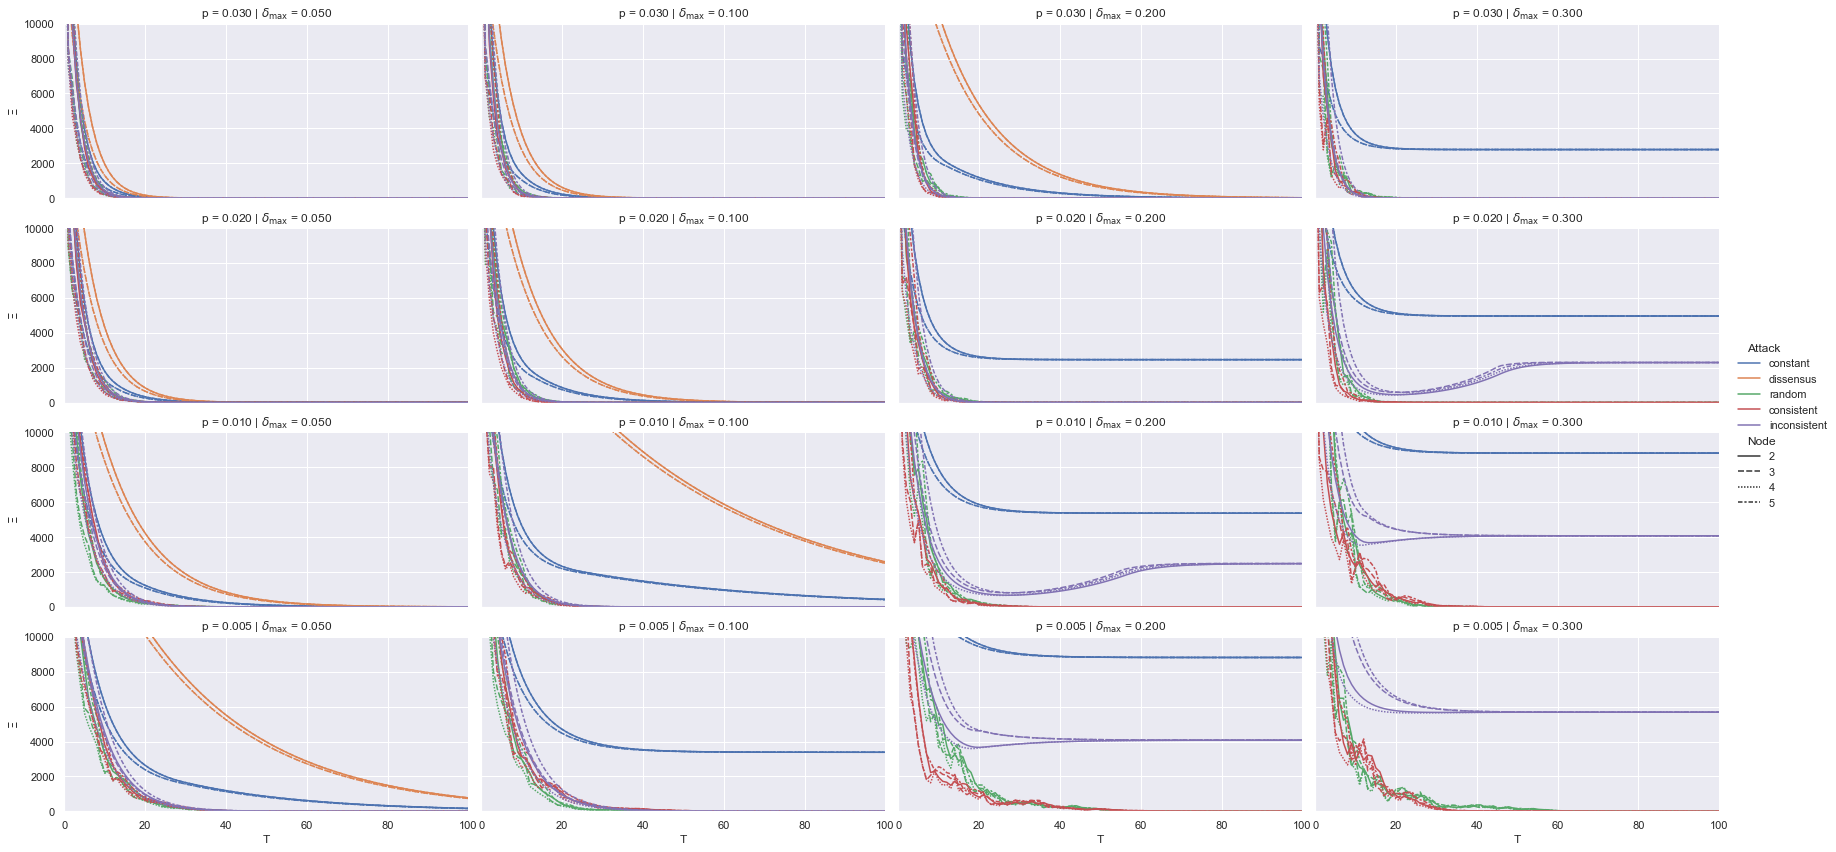

In [323]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue

    for t, e, cds in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        for i in range(len(cds)):
            stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cds[i], "T": t, "Attack": res['attack'], "Node": i+2})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y=r"$\Xi$", col=r"$\delta_{\max}$", row="p", kind='line', hue="Attack", style="Node", height=3, aspect=2)

g.set(xlim=(0, 100))
g.set(ylim=(0, 10000))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)